In [1]:
import matplotlib.pyplot as plt
import numpy as np

from dflat.initialize import focusing_lens
from dflat.metasurface import reverse_lookup_optimize, load_optical_model
from dflat.plot_utilities import mp_format
from dflat.propagation import PointSpreadFunction

(1, 1, 501, 501) (1, 1, 501, 501) (1, 1, 501, 501)


Text(0.5, 1.0, 'phase')

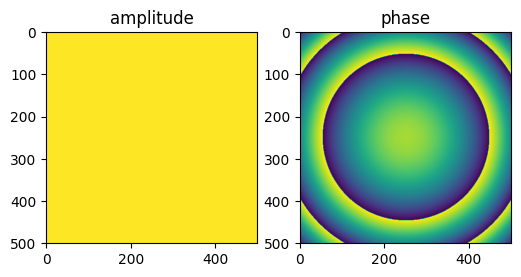

In [2]:
settings = {
    "in_size": [501, 501],
    "in_dx_m": [350e-9, 350e-9],
    "wavelength_set_m": [550e-9],
    "depth_set_m": [1e-2],
    "fshift_set_m": [[0.0, 0.0]],
    "out_distance_m": 1e-2,
    "aperture_radius_m": None,
    "radial_symmetry": False
    }
amp, phase, aperture = focusing_lens(**settings)
print(amp.shape, phase.shape, aperture.shape)

fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].imshow(amp[0,0]*aperture[0,0], vmin=0, vmax=1)
ax[0].set_title("amplitude")
ax[1].imshow(phase[0,0])
ax[1].set_title("phase")

In [3]:
# Reverse look-up to find the metasurface that implements the target profile
model_config_path = "metasurface/ckpt/Nanocylinders_TiO2_U180H600_Medium/config.yaml"
amp_ = amp[None]
phase_ = phase[None]
p_norm, p = reverse_lookup_optimize(
    amp_,
    phase_,
    [550e-9],
    model_config_path,
    lr=1e-1,
    err_thresh=1e-6,
    max_iter=200,)

Target Module: dflat.metasurface.optical_model.NeuralCells
Target Module: dflat.metasurface.nn_siren.SirenNet
Target: dflat.metasurface.optical_model.NeuralCells Loading from checkpoint /home/deanhazineh/Research/Dflat-pytorch-private_version2/dflat/metasurface/ckpt/Nanocylinders_TiO2_U180H600_Medium/model.ckpt as strict=True
Restored dflat.metasurface.optical_model.NeuralCells with 0 missing and 0 unexpected keys


Target Module: dflat.metasurface.optical_model.NeuralCells
Target Module: dflat.metasurface.nn_siren.SirenNet
Target: dflat.metasurface.optical_model.NeuralCells Loading from checkpoint /home/deanhazineh/Research/Dflat-pytorch-private_version2/dflat/metasurface/ckpt/Nanocylinders_TiO2_U180H600_Medium/model.ckpt as strict=True
Restored dflat.metasurface.optical_model.NeuralCells with 0 missing and 0 unexpected keys


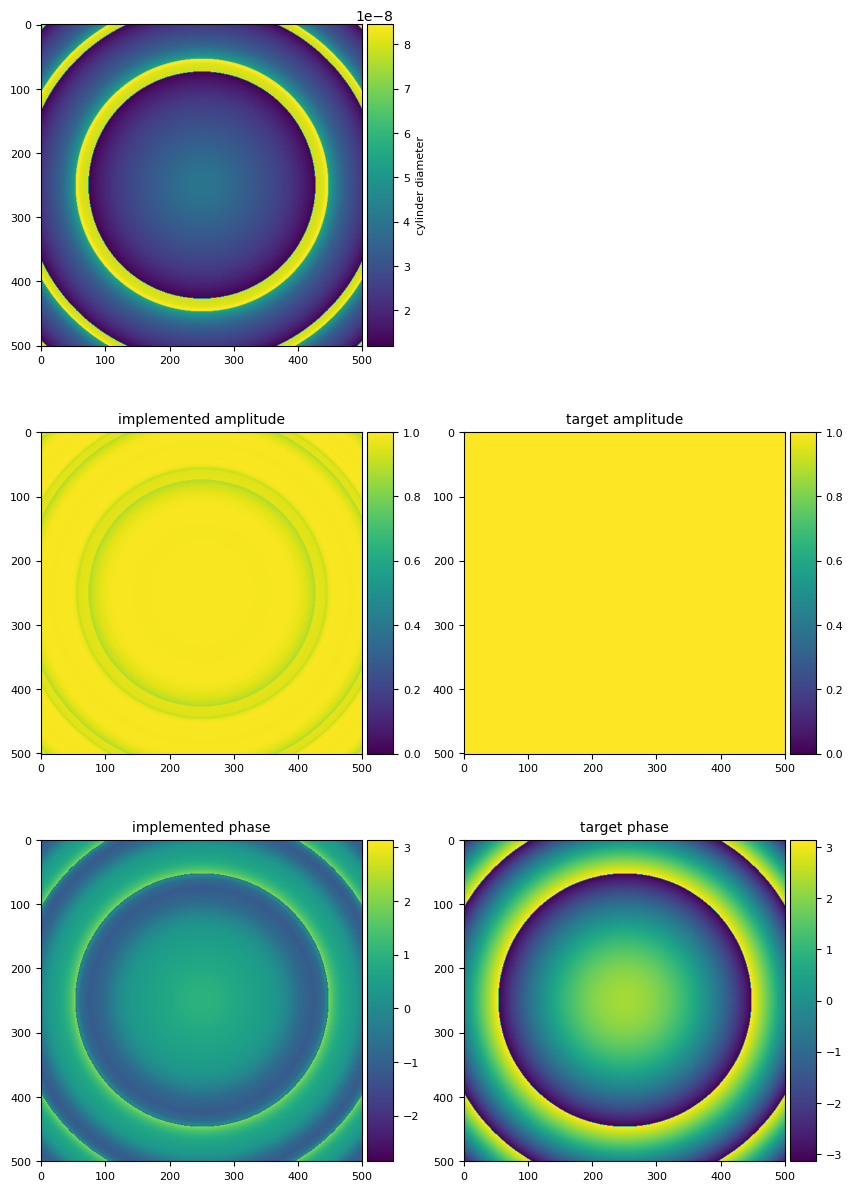

In [4]:
# As a check, lets call the optical model and see what this metasurface does vs what we desired
model = load_optical_model(model_config_path)
model = model.to("cuda")
est_amp, est_phase = model(p, np.array([550e-9]), pre_normalized=False)

fig, ax = plt.subplots(3,2, figsize=(10,15))
ax[0,0].imshow(p.squeeze())
mp_format.formatPlot(fig, ax[0,0], addcolorbar=True, setAspect="equal", cbartitle="cylinder diameter")
ax[0,1].axis('off')

ax[1,0].imshow(est_amp.squeeze().cpu().numpy(), vmin=0, vmax=1)
mp_format.formatPlot(fig, ax[1,0], title="implemented amplitude", addcolorbar=True, setAspect="equal")
ax[1,1].imshow(amp.squeeze(), vmin=0, vmax=1)
mp_format.formatPlot(fig, ax[1,1], title="target amplitude",  addcolorbar=True, setAspect="equal")


ax[2,0].imshow(est_phase.squeeze().cpu().numpy())
mp_format.formatPlot(fig, ax[2,0], title="implemented phase", addcolorbar=True, setAspect="equal")
ax[2,1].imshow(phase.squeeze())
mp_format.formatPlot(fig, ax[2,1], title="target phase", addcolorbar=True, setAspect="equal")

In [5]:
# Compute the point-spread function for this lens for different conditions
PSF = PointSpreadFunction(
    in_size=[501, 501],
    in_dx_m=[350e-9, 350e-9],
    out_distance_m=1e-2,
    out_size=[512, 512],
    out_dx_m=[1e-6,1e-6],
    out_resample_dx_m=None,
    radial_symmetry=False,
    diffraction_engine="ASM")

ps_locs = [[0.0, 0.0, 1e-3], [0.0, 0.0, 1e-2], [0.0, 0.0, 5e-2]]
sim_wl = [500e-9, 550e-9, 600e-9]
intensity, phase = PSF(est_amp, est_phase, sim_wl, ps_locs, aperture=None, normalize_to_aperture=True)
print(intensity.shape, phase.shape)

torch.Size([1, 1, 501, 501]) torch.Size([1, 1, 501, 501])
torch.Size([1, 1, 3, 3, 512, 512]) torch.Size([1, 1, 3, 3, 512, 512])


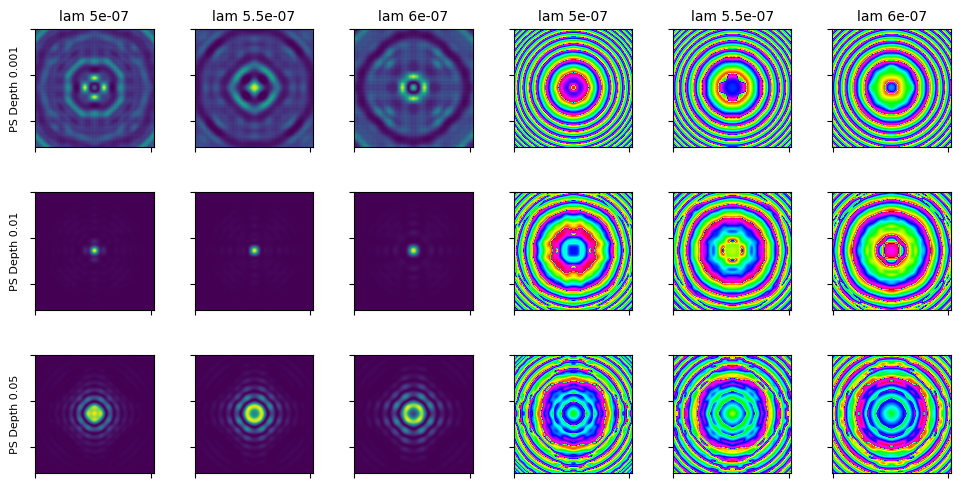

In [6]:
fig, ax = plt.subplots(3, 6, figsize=(12,6))

for z in range(3):

    for l in range(3):
        ax[z,l].imshow(intensity[0,0, z, l,:,:].cpu().numpy())
        mp_format.formatPlot(
            fig, 
            ax[z,l],
            title= f"lam {sim_wl[l]}" if z==0 else "",
            rmvxLabel=True,
            rmvyLabel=True, 
            setAspect="equal")
        
    for l in np.arange(3,6,1):
        ax[z,l].imshow(phase[0,0, z, l-3,:,:].cpu().numpy(), cmap='hsv')
        mp_format.formatPlot(
            fig, 
            ax[z,l],
            title= f"lam {sim_wl[l-3]}" if z==0 else "",
            rmvxLabel=True,
            rmvyLabel=True, 
            setAspect="equal")
    ax[z,0].set_ylabel(f"PS Depth {ps_locs[z][2]}")

In [7]:
# Write this lens to a gds file for fabrication
pfab = p.squeeze(0)
mask = np.ones(pfab.shape[0:2])
cell_size = [180e-9, 180e-9]
block_size =[180e-9, 180e-9]

print(pfab.shape, mask.shape)

from dflat.GDSII.assemble import assemble_nanocylinder_gds
assemble_nanocylinder_gds(pfab, mask, cell_size, block_size, savepath="./file.gds")




/home/deanhazineh/anaconda3/envs/dflat_pytorch_v2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(501, 501, 1) (501, 501)
Writing metasurface shapes to GDS File


100%|██████████| 501/501 [00:07<00:00, 66.66it/s]


Completed writing and saving metasurface GDS File: Time:  8.716597557067871
